In [515]:
from collections import Counter
import pandas as pd
import numpy as np
import shap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import json


In [516]:
df = pd.read_csv("resources\GPT4_few_shot.csv")
df.head()


,NLQ,PREDICTED SQL,GOLD SQL,DATABASE
0,How many singers do we have?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer
1,What is the total number of singers?,SELECT COUNT(*) FROM singer,SELECT count(*) FROM singer,concert_singer
2,"Show name, country, age for all singers ordere...","SELECT name, country, age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer
3,"What are the names, countries, and ages for ev...","SELECT Name, Country, Age FROM singer ORDER BY...","SELECT name , country , age FROM singer ORDE...",concert_singer
4,"What is the average, minimum, and maximum age ...","SELECT AVG(age), MIN(age), MAX(age) FROM singe...","SELECT avg(age) , min(age) , max(age) FROM s...",concert_singer


In [517]:
df = pd.read_csv("resources/GPT4_few_shot.csv")

def clean_sql(sql_string):
    while len(sql_string) != len(sql_string.replace("  ", " ")):
        sql_string = sql_string.replace("  ", " ")

    for symbol in [",", "<", ">", "=", "!", ":", ";", "[", "]", "%", "-", "+", "*", "/"]:
        sql_string = sql_string.replace(f" {symbol}", symbol)
        sql_string = sql_string.replace(f"{symbol} ", symbol)
    return sql_string

df["PREDICTED SQL"] = df["PREDICTED SQL"].apply(lambda x: clean_sql(x.lower()))
df["GOLD SQL"] = df["GOLD SQL"].apply(lambda x: clean_sql(x.lower()))

df[["PREDICTED SQL", "GOLD SQL"]].head()


,PREDICTED SQL,GOLD SQL
0,select count(*) from singer,select count(*) from singer
1,select count(*) from singer,select count(*) from singer
2,"select name,country,age from singer order by a...","select name,country,age from singer order by a..."
3,"select name,country,age from singer order by a...","select name,country,age from singer order by a..."
4,"select avg(age),min(age),max(age) from singer ...","select avg(age),min(age),max(age) from singer ..."


In [518]:
df['label'] = (df["PREDICTED SQL"] == df["GOLD SQL"]).astype(int)

df[['PREDICTED SQL', 'GOLD SQL', 'label']].head(10)

,PREDICTED SQL,GOLD SQL,label
0,select count(*) from singer,select count(*) from singer,1
1,select count(*) from singer,select count(*) from singer,1
2,"select name,country,age from singer order by a...","select name,country,age from singer order by a...",1
3,"select name,country,age from singer order by a...","select name,country,age from singer order by a...",1
4,"select avg(age),min(age),max(age) from singer ...","select avg(age),min(age),max(age) from singer ...",1
5,"select avg(age),min(age),max(age) from singer ...","select avg(age),min(age),max(age) from singer ...",1
6,"select name,song_release_year from singer wher...","select song_name,song_release_year from singer...",0
7,"select name,song_release_year from singer wher...","select song_name,song_release_year from singer...",0
8,select distinct country from singer where age>20,select distinct country from singer where age>20,1
9,select distinct country from singer where age>20,select distinct country from singer where age>20,1


In [519]:
label_counts = df['label'].value_counts()
label_counts


label
0    693
1    341
Name: count, dtype: int64

In [520]:
num_rows = df.shape[0]
num_rows

1034

In [521]:
df[df['label'] == 0].head(10)

,NLQ,PREDICTED SQL,GOLD SQL,DATABASE,label
6,Show the name and the release year of the song...,"select name,song_release_year from singer wher...","select song_name,song_release_year from singer...",concert_singer,0
7,What are the names and release years for all t...,"select name,song_release_year from singer wher...","select song_name,song_release_year from singer...",concert_singer,0
11,How many singers are from each country?,"select count(*),country from singer group by c...","select country,count(*) from singer group by c...",concert_singer,0
16,What is the maximum capacity and the average o...,"select max(capacity),avg(capacity) from stadium","select max(capacity),average from stadium",concert_singer,0
18,What is the name and capacity for the stadium ...,"select name,capacity from stadium where averag...","select name,capacity from stadium order by ave...",concert_singer,0
19,What is the name and capacity for the stadium ...,"select name,capacity from stadium where averag...","select name,capacity from stadium order by ave...",concert_singer,0
21,How many concerts occurred in 2014 or 2015?,select count(*) from concert where year in (20...,select count(*) from concert where year=2014 o...,concert_singer,0
22,Show the stadium name and the number of concer...,"select t1.name,count(t2.concert_id) from stadi...","select t2.name,count(*) from concert as t1 joi...",concert_singer,0
23,"For each stadium, how many concerts play there?","select count(concert_id),stadium_id from conce...","select t2.name,count(*) from concert as t1 joi...",concert_singer,0
24,Show the stadium name and capacity with most n...,"select t1.name,t1.capacity from stadium as t1 ...","select t2.name,t2.capacity from concert as t1 ...",concert_singer,0


In [522]:
print(df['label'].value_counts())  # Um die Verteilung der Klassen zu überprüfen

label
0    693
1    341
Name: count, dtype: int64


In [523]:
df.to_csv("output/labeled_sql_data.csv", index=False)

In [524]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def extract_features(question):
    doc = nlp(question)

    # general
    features = {
        "num_tokens": len(doc),
        "is_wh_question": any(token.text.lower() in ["what", "where", "who", "how", "why"] for token in doc),
        "has_negation": any(token.text.lower() in ["not", "no"] for token in doc),
        "num_entities": len(doc.ents),
        "num_unique_dependencies": len(set(token.dep_ for token in doc)),
        "dependency_tree_depth": max([token.head.i for token in doc] + [0]),
        "dependency_depth": max([len(list(token.subtree)) for token in doc]),
    }

    # POS-Tagging
    pos_counts = Counter(token.pos_ for token in doc)
    features.update({
        "num_nouns": pos_counts.get("NOUN", 0),
        "num_verbs": pos_counts.get("VERB", 0),
        "num_adjectives": pos_counts.get("ADJ", 0),
        "num_adverbs": pos_counts.get("ADV", 0),
    })

    # count entities for type
    entity_counts = Counter(ent.label_ for ent in doc.ents)
    features.update({
        "num_persons": entity_counts.get("PERSON", 0),
        "num_orgs": entity_counts.get("ORG", 0),
        "num_locations": entity_counts.get("GPE", 0),
    })

    # frequency profile (without stopwords abd interpunktion)
    word_frequencies = Counter(token.text.lower() for token in doc if not token.is_stop and not token.is_punct)
    features["frequent_words"] = sum(word_frequencies.values())
    features["rare_words"] = sum(1 for count in word_frequencies.values() if count == 1)

    return features


In [525]:
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
}

## Without PCA

In [526]:
X = df.apply(lambda row: extract_features(row['NLQ']), axis=1).apply(pd.Series)

X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    #print(f"Evaluating {name}...")

    # Cross-Validation (5 Folds)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    mean_cv_score = cv_scores.mean()

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "mean_cv_score": mean_cv_score,
        "test_accuracy": acc,
        "classification_report": classification_report(y_test, y_pred)
    }
    
    #print(f"{name}: CV Mean Accuracy = {mean_cv_score:.4f}, Test Accuracy = {acc:.4f}")

best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name} with Test Accuracy {results[best_model_name]['test_accuracy']:.4f}")
print(f"\nClassification Report for {best_model_name}:\n{results[best_model_name]['classification_report']}")


Best Model: Logistic Regression with Test Accuracy 0.7343

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       137
           1       0.74      0.33      0.46        70

    accuracy                           0.73       207
   macro avg       0.74      0.64      0.64       207
weighted avg       0.74      0.73      0.70       207



Model has trouble classifying 1. A lot of false negatives.
Model good for 0.

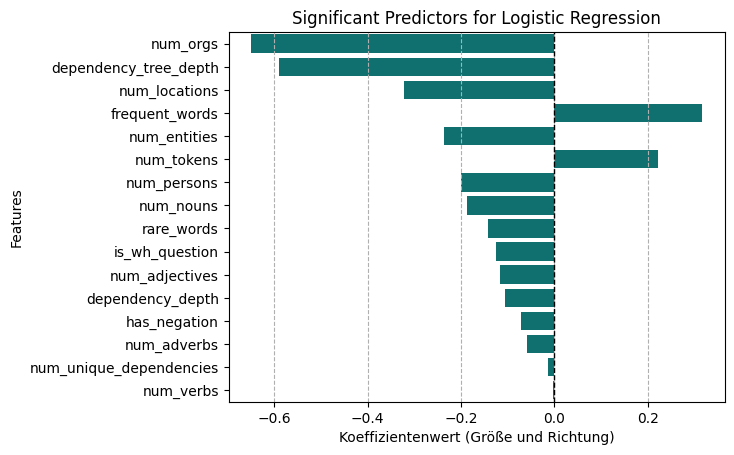

In [527]:
# Extract the Koeffizienten
coefficients = best_model.coef_[0]
feature_names = X.columns

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

plt.figure()
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, color="teal")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title('Significant Predictors for Logistic Regression')
plt.grid(True, axis='x', linestyle='--')
plt.xlabel("Koeffizientenwert (Größe und Richtung)")
plt.ylabel("Features")
plt.show()

## Try Classifier on test.json

In [528]:
with open('spider_data/spider_data/test.json', 'r') as f:
    test_data = json.load(f)

test_df = pd.DataFrame(test_data)
test_df

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,soccer_3,SELECT count(*) FROM club,"[SELECT, count, (, *, ), FROM, club]","[select, count, (, *, ), from, club]",How many clubs are there?,"[How, many, clubs, are, there, ?]","{'from': {'table_units': [['table_unit', 0]], ..."
1,soccer_3,SELECT count(*) FROM club,"[SELECT, count, (, *, ), FROM, club]","[select, count, (, *, ), from, club]",Count the number of clubs.,"[Count, the, number, of, clubs, .]","{'from': {'table_units': [['table_unit', 0]], ..."
2,soccer_3,SELECT Name FROM club ORDER BY Name ASC,"[SELECT, Name, FROM, club, ORDER, BY, Name, ASC]","[select, name, from, club, order, by, name, asc]",List the name of clubs in ascending alphabetic...,"[List, the, name, of, clubs, in, ascending, al...","{'from': {'table_units': [['table_unit', 0]], ..."
3,soccer_3,SELECT Name FROM club ORDER BY Name ASC,"[SELECT, Name, FROM, club, ORDER, BY, Name, ASC]","[select, name, from, club, order, by, name, asc]","What are the names of clubs, ordered alphabeti...","[What, are, the, names, of, clubs, ,, ordered,...","{'from': {'table_units': [['table_unit', 0]], ..."
4,soccer_3,"SELECT Manager , Captain FROM club","[SELECT, Manager, ,, Captain, FROM, club]","[select, manager, ,, captain, from, club]",What are the managers and captains of clubs?,"[What, are, the, managers, and, captains, of, ...","{'from': {'table_units': [['table_unit', 0]], ..."
...,...,...,...,...,...,...,...
2142,advertising_agencies,"SELECT staff_id , staff_details FROM staff WH...","[SELECT, staff_id, ,, staff_details, FROM, sta...","[select, staff_id, ,, staff_details, from, sta...",Return the ids and details of staff who have a...,"[Return, the, ids, and, details, of, staff, wh...","{'from': {'table_units': [['table_unit', 1]], ..."
2143,advertising_agencies,"SELECT T1.client_id , T1.sic_code , T1.agenc...","[SELECT, T1.client_id, ,, T1.sic_code, ,, T1.a...","[select, t1, ., client_id, ,, t1, ., sic_code,...","What are the id, sic code and agency id of the...","[What, are, the, id, ,, sic, code, and, agency...","{'from': {'table_units': [['table_unit', 2], [..."
2144,advertising_agencies,"SELECT T1.client_id , T1.sic_code , T1.agenc...","[SELECT, T1.client_id, ,, T1.sic_code, ,, T1.a...","[select, t1, ., client_id, ,, t1, ., sic_code,...","Return the ids, sic codes, and agency ids of c...","[Return, the, ids, ,, sic, codes, ,, and, agen...","{'from': {'table_units': [['table_unit', 2], [..."
2145,advertising_agencies,"SELECT T1.start_date_time , T1.end_date_time ...","[SELECT, T1.start_date_time, ,, T1.end_date_ti...","[select, t1, ., start_date_time, ,, t1, ., end...","List the start time, end time of each meeting,...","[List, the, start, time, ,, end, time, of, eac...","{'from': {'table_units': [['table_unit', 4], [..."


In [529]:
test_features_extracted = test_df['question'].apply(lambda q: extract_features(q)).apply(pd.Series)
test_features_extracted

,num_tokens,is_wh_question,has_negation,num_entities,num_unique_dependencies,dependency_tree_depth,dependency_depth,num_nouns,num_verbs,num_adjectives,num_adverbs,num_persons,num_orgs,num_locations,frequent_words,rare_words
0,6,True,False,0,5,3,6,1,0,1,1,0,0,0,1,1
1,6,False,False,0,6,3,6,2,1,0,0,0,0,0,3,3
2,10,False,False,0,8,8,10,3,2,1,0,0,0,0,5,5
3,10,True,False,0,9,7,10,2,1,0,1,0,0,0,4,4
4,9,True,False,0,9,6,9,3,0,0,0,0,0,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,23,True,False,1,15,21,23,7,3,1,0,0,0,0,10,6
2143,25,True,False,1,15,23,25,6,2,0,0,0,0,0,10,8
2144,22,True,False,1,13,20,22,8,3,0,0,0,0,0,11,9
2145,20,False,False,0,11,18,20,7,3,1,0,0,0,0,11,7


In [530]:
X_test_new_scaled = scaler.transform(test_features_extracted)

y_pred_new = best_model.predict(X_test_new_scaled)

y_true = np.ones(len(y_pred_new))

accuracy = accuracy_score(y_true, y_pred_new)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(y_true, y_pred_new))


Test Accuracy: 0.1900
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.19      0.32      2147

    accuracy                           0.19      2147
   macro avg       0.50      0.10      0.16      2147
weighted avg       1.00      0.19      0.32      2147



C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: Unde

In [531]:
np.unique(y_pred_new, return_counts=True)

(array([0, 1]), array([1739,  408], dtype=int64))

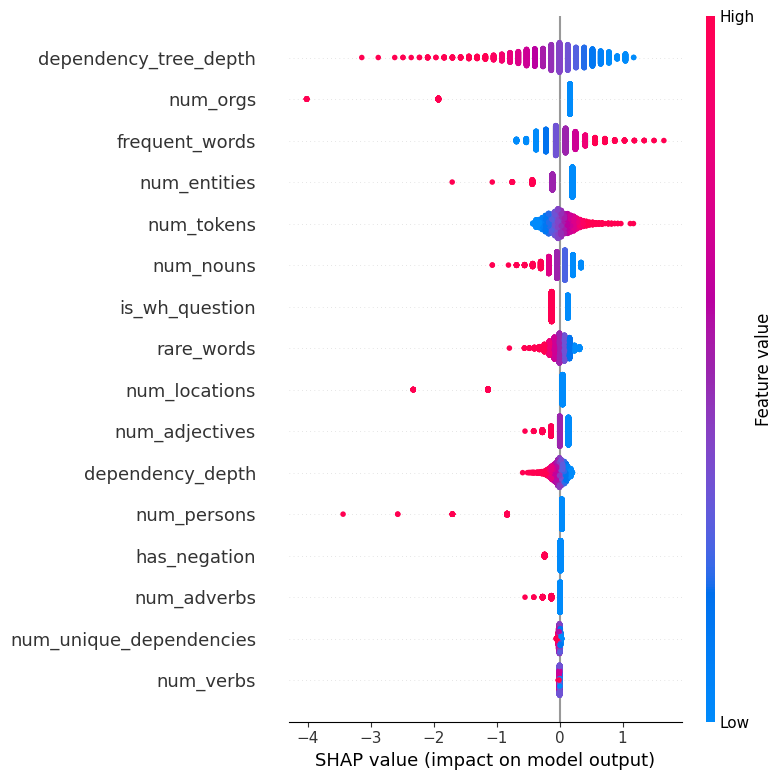

In [532]:
explainer = shap.Explainer(best_model, X_train_scaled) 
shap_values = explainer(X_test_new_scaled)

shap.summary_plot(shap_values, X_test_new_scaled, feature_names=test_features_extracted.columns)

## With PCA

In [533]:
X_pca = df['NLQ'].apply(lambda q: extract_features(q)).apply(pd.Series)
y_pca = df['label']

X_pca = X_pca.apply(pd.to_numeric, errors='coerce').fillna(0)

scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_pca)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_scaled_pca, y_pca, test_size=0.2, random_state=42
)

results_pca = {}

for n_components in range(1, X_train_pca.shape[1] + 1):
    pca = PCA(n_components=n_components)
    X_train_pca_transformed = pca.fit_transform(X_train_pca)
    X_test_pca_transformed = pca.transform(X_test_pca)

    for name, model in models.items():
        cv_scores_pca = cross_val_score(model, X_train_pca_transformed, y_train_pca, cv=5, scoring='accuracy')
        mean_cv_score_pca = cv_scores_pca.mean()

        model.fit(X_train_pca_transformed, y_train_pca)
        y_pred_pca = model.predict(X_test_pca_transformed)
        acc_pca = accuracy_score(y_test_pca, y_pred_pca)

        results_pca[(name, n_components)] = {
            "mean_cv_score": mean_cv_score_pca,
            "test_accuracy": acc_pca,
            "classification_report": classification_report(y_test_pca, y_pred_pca)
        }

        print(f"Model: {name}, PCA Components: {n_components}, CV Mean Accuracy = {mean_cv_score_pca:.4f}, Test Accuracy = {acc_pca:.4f}")

best_result_key_pca = max(results_pca, key=lambda x: results_pca[x]['test_accuracy'])
best_model_name_pca, best_n_components_pca = best_result_key_pca

best_model_pca = models[best_model_name_pca]
best_pca_transformer = PCA(n_components=best_n_components_pca)

X_train_pca_best = best_pca_transformer.fit_transform(X_train_pca)
best_model_pca.fit(X_train_pca_best, y_train_pca)

print(f"\nBest PCA Model: {best_model_name_pca} with {best_n_components_pca} PCA Components, Test Accuracy = {results_pca[best_result_key_pca]['test_accuracy']:.4f}")
print(f"\nPCA Classification Report:\n{results_pca[best_result_key_pca]['classification_report']}")

Model: Naive Bayes, PCA Components: 1, CV Mean Accuracy = 0.6771, Test Accuracy = 0.6908
Model: Decision Tree, PCA Components: 1, CV Mean Accuracy = 0.6021, Test Accuracy = 0.5845
Model: Logistic Regression, PCA Components: 1, CV Mean Accuracy = 0.6735, Test Accuracy = 0.6860
Model: Random Forest, PCA Components: 1, CV Mean Accuracy = 0.5997, Test Accuracy = 0.5894
Model: Naive Bayes, PCA Components: 2, CV Mean Accuracy = 0.6687, Test Accuracy = 0.6667
Model: Decision Tree, PCA Components: 2, CV Mean Accuracy = 0.6252, Test Accuracy = 0.6184
Model: Logistic Regression, PCA Components: 2, CV Mean Accuracy = 0.6771, Test Accuracy = 0.6860
Model: Random Forest, PCA Components: 2, CV Mean Accuracy = 0.6638, Test Accuracy = 0.6377
Model: Naive Bayes, PCA Components: 3, CV Mean Accuracy = 0.7001, Test Accuracy = 0.7053
Model: Decision Tree, PCA Components: 3, CV Mean Accuracy = 0.6047, Test Accuracy = 0.5990
Model: Logistic Regression, PCA Components: 3, CV Mean Accuracy = 0.7001, Test Accur

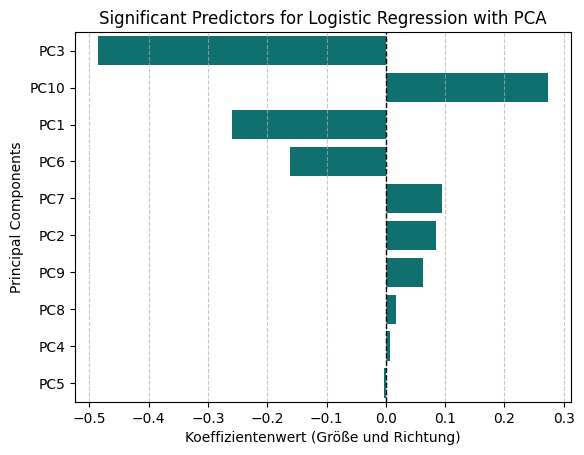

Top 2:
PC1: num_tokens, dependency_tree_depth
PC2: is_wh_question, num_adjectives
PC3: num_entities, num_orgs
PC4: has_negation, num_adjectives
PC5: num_locations, num_adverbs
PC6: num_adverbs, num_orgs
PC7: num_persons, num_orgs
PC8: num_adjectives, num_nouns
PC9: num_verbs, has_negation
PC10: rare_words, is_wh_question


In [534]:
coefficients = best_model_pca.coef_[0]
feature_names = [f'PC{i+1}' for i in range(len(coefficients))]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

plt.figure()
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, color="teal")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title('Significant Predictors for Logistic Regression with PCA')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.xlabel("Koeffizientenwert (Größe und Richtung)")
plt.ylabel("Principal Components")
plt.show()

loading_matrix = pd.DataFrame(best_pca_transformer.components_.T, index=X_pca.columns, columns=feature_names)

top_features_per_pc = {}
for pc in feature_names:
    top_features_per_pc[pc] = loading_matrix[pc].abs().nlargest(2).index.tolist()

print("Top 2:")
for pc, features in top_features_per_pc.items():
    print(f"{pc}: {', '.join(features)}")

In [535]:
# Standardize the new test data using the same scaler
X_test_new_scaled = scaler_pca.transform(test_features_extracted)

# Apply PCA transformation to the new test data to reduce it to 10 components
X_test_new_pca = best_pca_transformer.transform(X_test_new_scaled)

# Use the trained logistic regression model to predict on the transformed test data
y_pred_new = best_model_pca.predict(X_test_new_pca)

y_true = np.ones(len(y_pred_new))

accuracy = accuracy_score(y_true, y_pred_new)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(y_true, y_pred_new))


Test Accuracy: 0.1896
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.19      0.32      2147

    accuracy                           0.19      2147
   macro avg       0.50      0.09      0.16      2147
weighted avg       1.00      0.19      0.32      2147



C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: Unde